# Clasificación naive-Bayes de secuencias de ADN



La __transcripción__ del ADN es el proceso en el que se transfiere la información genética contenida en el ADN, mediante la síntesis de otra molécula llamada ARN. Este proceso lo realizan las enzimas __ARN polimerasas__ y tiene 3 etapas:

- __Iniciación__: la ARN polimerasa se une a una secuencia de ADN (promotor) , que se encuentra al inicio de un gen (cada gen tiene su propio promotor) y se genera un cebador de ARN al que se le van a unir los nucleótidos complementarios de la cadena molde de ADN.
- __Elongación__: la ARN polimerasa ’lee’ base a base el molde de ADN y va uniendo secuencialmente, a partir del cebador, los nucleótidos de ARN complementarios a la secuencia molde formando una cadena que crece en dirección $5' -> 3'$. Esa cadena de ARNm (ARN mensajero), se llama transcrito y tiene la misma información, pero complementaria, que la cadena de ADN molde y en lugar de la base timina (T) tiene Uracilo (U).
- __Terminación__: una vez que la ARN polimerasa llega a las secuencias de terminación del ADN, la ARN polimerasa libera el transcrito.

Después de estas tres fases, en eucariotas, el transcrito se modifica. Primero se le añade una caperuza al extremo 5’(CAP 5’) y una cola de adeninas (poli-A) al extremo 3’. También, se produce la escisión (eliminación) de los intrones (secuencias no codificantes) y la unión de los exones (secuencias codificantes) en un proceso llamado __splicing__.

El __ARNm__ maduro luego va al citoplasma y se produce su __traducción a polipéptido__. En el proceso de traducción se genera una cadena polipeptídica a partir del transcrito maduro utilizando el código genético como referencia y con la ayuda del __ARNt__ (ARN transferente) y las dos subunidades del ribosoma. Al igual que la transcripción, la traducción tiene tres etapas, iniciación, elongación y terminación:

- __Iniciación__: el ribosoma y el ARNt se unen al ARNm y forman el complejo de iniciación.
- __Elongación__: proceso entre ARNt y ARNm para formar los sucesivos enlaces peptídicos desde el sitio A (codón) del ribosoma.
- __Terminación__: entra al codón del ribosoma un codón de stop del ARNm, que no es reconocido por el ARNt y se produce la liberación del polipéptido y el desacoplamiento de las subunidades del ribosoma.

Se acepta como definición de __gen__ a todo segmento de ADN que se encuentra a continuación de un promotor y que puede ser transcrito, originando un ARN funcional (ARNm, ARNt, ARNsn, ...).

La __transcriptoma__ estudia los transcritos que se forma en el proceso de copia de la información genética contenida en el ADN en forma de ARN (__transcripción__). Actualmente existen tecnologías de secuenciación masiva llamadas __NGS__ (Next Generation Sequencing). La tecnología NGS más popular es la secuenciación directa de ARN (__ARN-seq__).

La metodología __ARN-seq__ tiene las etapas:
- Extracción del ARN total desde la muestra biológica.
- Fragmentación del ARN.
- Generación de librerías ARN-seq.
- Amplificación del ADN circular (por _reacción en cadena de la polimerasa_) y secuenciación para obtener pequeñas secuencias de nucleótidos (__reads__).

Consorcios científicos proporcionan gran cantidad datos de transcriptoma, genoma y proteoma:

- Proyecto __ENCODE__ (ENCyclopedia Of DNA Elements).
- Proyecto __GTEX__ (genotype-tissue expression).

Para datos de expresión génica, el clustering se puede realizar en función de los genes o de las muestras. En la agrupación basada en genes (_gene-based clustering_), los genes se consideran objetos mientras que las muestras se consideran características, mientras que en la agrupación basada en muestras, las muestras se pueden segregar en grupos idénticos donde los genes se tratan como características y las muestras como objetos.

## "Corta-pega" en RNA:

- En algunos genes, las secciones del DNA que codifican proteínas (__exones__) a veces están interrumpidas por regiones no
codificantes (__intrones__).

- El proceso de "corta-pega" del RNA __quita los intrones__ del mRNA para generar la secuencia final que codifica la proteina, dejando únicamente los exones en el RNA editado. Los intrones vienen caracterizados por un sitio __donor__ (frontera exón-intrón) y uno __aceptor__ (frontera intrón-exón).

Una animación del proceso se muestra en: https://dnalc.cshl.edu/resources/3d/rna-splicing.html

### Problema 
¿__a partir de una lista de secuencias de DNA de las que conocemos "sitios donores", ¿podemos predecir los sitios donores en nuevas secuencias__?

## Conjunto de datos de entrenamiento
El conjunto de datos esta en el archivo 'splice.txt' que puedes descargar de Moodle. Las primeras líneas del archivo son (hemos truncado las ultimas posiciones de las secuencias solo para ajustarlas al texto de este documento):

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/splice.txt')
df.head()

,Class,Instance,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


Todas las secuencias tienen 60 pares de bases. La primera columna (__Class__) indica la clase a la que pertenece la secuencia: EI para las que proporcionan un salto exon-intrón (donores); IE para las secuencias que contienen una frontera intron-exón (aceptores); N para aquellas secuencias que no son ni EI ni IE. 

La segunda columna (__Instance__) es una etiqueta para cada una de las instancias (filas), y la tercera columna da la __secuencia__ correspondiente en terminos del alfabeto A, T, C y G.

## Preproceso de las secuencias

Algunas de las secuencias tienen ambiguedad en determinadas posiciones, de forma que incluyen las letras D, N, S o R de acuerdo con la siguiente tabla:

| Letra | Significado |
| ----- | ------- |
| D | A o G o T |
| N | A o G o T o C |
| S | C o G |
| R | A o G |

Estos caracteres ambiguos aparecen en muy pocas instancias, así que se van a eliminar de los datos para simplificar el analisis. Primero se realiza un proceso de filtrado para saber cuantas secuencias quedan:


In [2]:
df['Sequence'].str.contains("D|N|S|R").value_counts()

Sequence
False    3175
True       15
Name: count, dtype: int64

In [3]:
df[df['Sequence'].str.contains("D|N|S|R")]

,Class,Instance,Sequence
107,EI,HUMALPI1-DONOR-42,CACACAGGGCACCCCCTCANNNNNNNNNNNNNNNNNNNNNNNNNNN...
239,EI,HUMCSPB-DONOR-2010,AACTTCTCCAACGACATCATGCTACTGCAGGTNAGGCACACTCCTG...
365,EI,HUMH19-DONOR-2562,TCTGGGCTCCCAGAACCCACAACATGAAAGGTGAGGGNCTTCCTGC...
366,EI,HUMH19-DONOR-2766,ACTACCTGACTCAGGAATCGGCTCTGGAAGGTGAGCACCAGCGCTC...
485,EI,HUMMHCD8A-DONOR-1087,TCAGCCACTTCGTGCCGGTCTTCCTGCCAGGTCCGCGCGCCGGGTT...
1247,IE,HUMMHB27B-ACCEPTOR-1202,DGACGGGGCTGACCGCGGGGGCGGGTCCAGGGTCTCACACCCTCCA...
1440,IE,HUMSPRO-ACCEPTOR-2841,ATACCCCTTTTCACTTTCCCCACCTCTTAGGGTARTCAGTACTGGC...
1441,IE,HUMSPRO-ACCEPTOR-3195,CCCTCCTAATGCCCACCATCCCGTCCTCAGGGAAASAGTACTGGGA...
1804,N,HUMC1A1-NEG-3901,ATGGCCTACATGGGTGTGGGTGCTGCAATTTCCGCTNCGGCAGACA...
2069,N,HUMFERG2-NEG-1,GGATCCCTAGTATAACACATTCAGTGTTCCCCNTTTCAGCCCNTTT...


Finalmente se __borran__ los registros de secuencia ambigua

_Nota_: Hay que recordar que en una lista de datos con con _true_ se copian y ~(Alt-126 o insertar símbolo) niega.

In [4]:
df = df[~df['Sequence'].str.contains("D|N|S|R")]
df

,Class,Instance,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...
...,...,...,...
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTTCTCTCCTCTTCTC...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAAGCACCTGGAGAAGC...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCGGTCCCCGGCCGCGGCC...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTGCTAGATAACCAAATTAA...


### Obtener dos subconjuntos, uno de entrenamiento y otro de validación

Divide el conjunto de datos en una parte para entrenamiento y otra parte para validacion, empleando muestreo aleatorio sin repetición. Reserva un 70 % de las instancias para entrenamiento y un 30 % para el conjunto de validacion

In [5]:
from sklearn.model_selection import train_test_split
X, y = df.values[:,2], df.values[:,0]
X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.7, random_state=0, stratify=y, shuffle=True)
X_train

array(['GATGTTAACCATTCTCCTTCTCCCCAACAGTTCCCCAGGGACCTCTCTCTAATCAGCCCT',
       'GTCTTTGCTTTTCTCTGTATTATATCAAACATTGGGAAATTCAGCCTCTCCAGGCGATGG',
       'CCTGTCTCCTTGCCTGCCCCACCGTGTCAGGACTACTCCGCAGCTCCCCGGGGCCGATTT',
       ...,
       'GCTAATAAAAACAAGCACTATTGTTCAACTTTTAGGTGTGTGTACTTTGGAGCCACCATT',
       'CTTAGAGTAGTTAAAATTTTCAAACTGAGATTTTAAAACTGTAATTTATTTAAAGGGTTA',
       'CTTGCACATACCTATGCTTCAAGAAATCCCAACATGAAGAAAGGAGACGAGTGTAAAAAC'],
      dtype=object)

## Se calculan las probabilidades de cada clase en función de la posición

Sobre el conjunto de entrenamiento, <b>X_train</b> e <b>y_train</b>.

Crear una lista de nombre, por ejemplo, __frecuencias__ de tres dimensiones por clase, letra, posición. Hacer un recuento de las letras por clase y posición y guardar el resultado en la variable frecuencias. Finalmente dividir el recuento por el número de registros que tiene cada clase para obtener la frecuencia.

Sobre una lista de nombre, por ejemplo, __probaClase__ guardar la frecuencia de cada clase.

In [10]:
X_60 = [[letra for letra in fila] for fila in X_train]
y_real = y_train
clases = list(np.unique(y_real))
letras = list(np.unique(X_60[0]))
numClases = len(clases)
numLetras = len(letras)
numPosicion = len(X_60[0])
#frecuencias = np.asarray([[[0 for i in range(numPosicion)] for j in range(numLetras) ] for k in range(numClases)], dtype=np.float64)
frecuencias = np.zeros((numClases, numPosicion, numLetras), dtype=np.float64)
### Se recuenta el nº de letras que hay en cada clase, posición y tipo de letra
for fila, cl in zip(X_60, y_real):
    for pos in range(numPosicion):
        letra = fila[pos]
        iClas = clases.index(cl)
        iLetr = letras.index(letra)
        frecuencias[iClas][pos][iLetr] +=1
### Por último se divide por el nº de elementos en cada clase y se almacena la probabilidad de clase
probaClases = [0 for i in range(numClases)]
for i in range(numClases):
    cl = clases[i]
    frecuencias[i] = frecuencias[i] / len(y_real[y_real == cl])
    probaClases[i] = len(y_real[y_real == cl]) / len(y_real)

### Se representa la probabilidad clase a clase de cada letra en su posición

Elegir 4 colores para cada una de las letras.
Hacer un plot múltiple, con 3 subplots por cada una de las clase. Por ejemplo:

__fig, axs = plt.subplots(numClases, figsize=(15,10))__

Crear una lista con valores de 0 a 59 para construir los valores X de cada subplot y en Y poner las frecuencias para cada una de las clases. Pasar a scatter en cada subplot un bloque completo por letra.

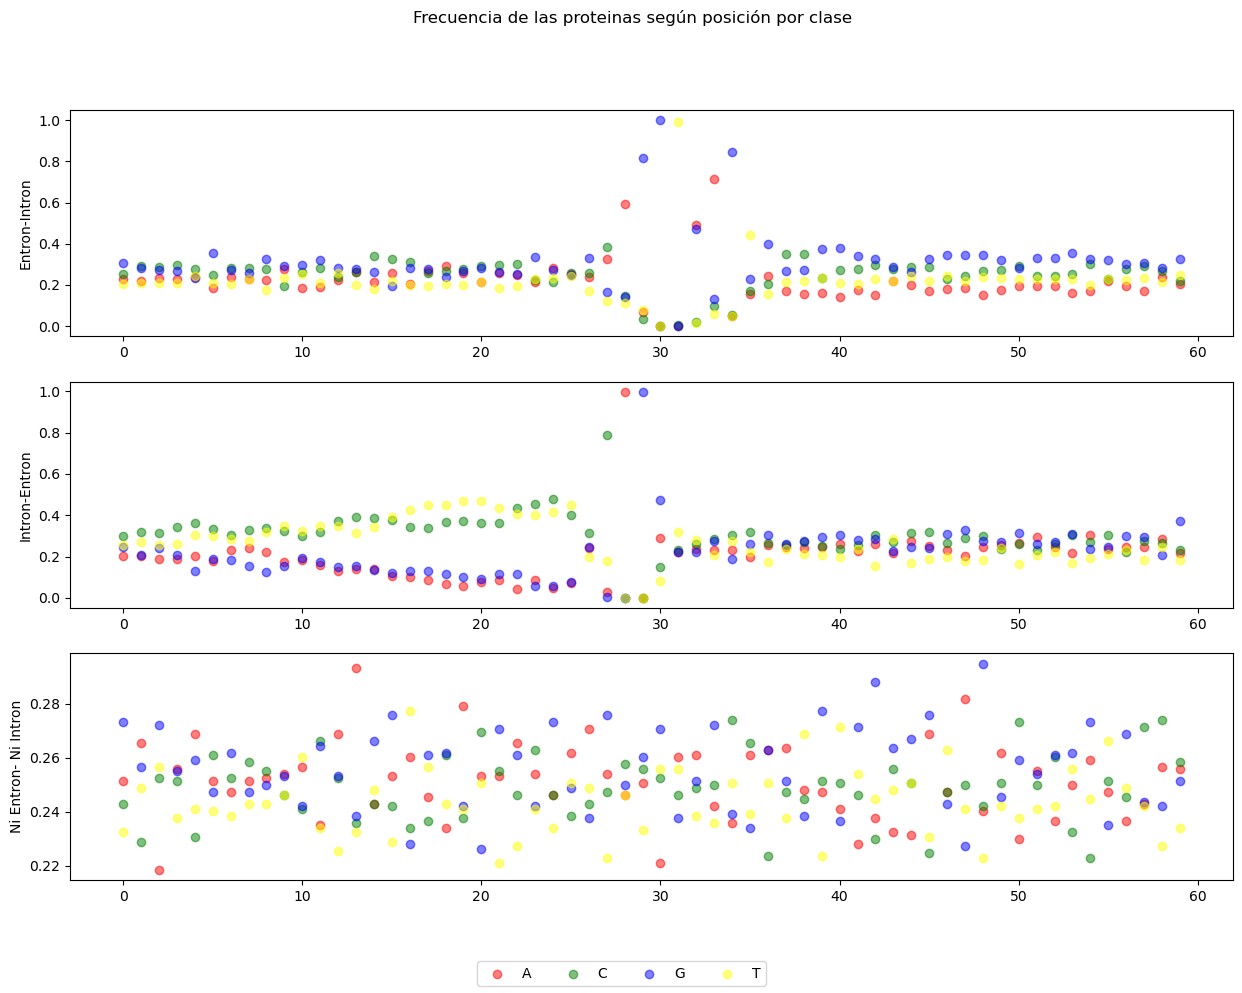

In [15]:
import matplotlib.pyplot as plt
color = ['red', 'green', 'blue', 'yellow']
iClas = 0
lstX = [i for i in range(numPosicion)]
nombreClases=['Entron-Intron', 'Intron-Entron', 'Ni Entron- Ni Intron']

fig, axs = plt.subplots(numClases, figsize=(15,10))
fig.suptitle('Frecuencia de las proteinas según posición por clase')
for iClas in range(numClases):
    for iLetr in range(numLetras):
        axs[iClas].scatter(lstX, frecuencias[iClas,:,iLetr], alpha=0.5, c=color[iLetr], marker='o', label=letras[iLetr])

for ax , nomCl in zip(axs.flat, nombreClases):
    ax.set(ylabel=nomCl)
fig.legend(labels=letras, loc="lower center", ncol=numLetras)
plt.show()

### Se evalua el conjunto de Pruebas (test) con las frecuencias anteriores

Ir leyendo fila a fila la matriz X_test y calcular la frecuencia de cada clase $k$ valor de letra $p$ en la posición $i$ y obtener como clase aquella de mayor valor de acuerdo a:


$$ clase(\bar{x}) = \underset{k \in \{1,...,m\}}{\arg\max} \frac{n_k}{N}\prod\limits_{i=1}^{n} f_{k,i}(p)$$

Donde $f_{k,i}(p)=\frac{n_{k,i,p}}{n_k}$

Además $n_{k,i,p}$ es el número de elementos del conjunto de entrenamiento que cumple $x_i=p$ además de $y=k$

Finalmente $n_k$ es el número de elementos del conjunto de entrenamiento que cumple $y=k$

In [16]:
aciertos=0
X_60 = [[letra for letra in fila] for fila in X_test]
y_real = y_test
for fila, claseOk in zip(X_60, y_real):
    probabilidad = [prob for prob in probaClases]
    for iCl in range(numClases):
        for pos in range(numPosicion):
            letra = fila[pos]
            iLetr = letras.index(letra)
            probabilidad[iCl] *= frecuencias[iCl][pos][iLetr]

    claseEstimada = clases[np.argmax(probabilidad)]
    if claseEstimada == claseOk:
        aciertos += 1
print("Porcentaje de aciertos=", 100*aciertos/len(y_real))

Porcentaje de aciertos= 94.43861490031479


## Implementación con la librería sk-learn

### Primero se prepara la matriz X de los conjuntos de entranamiento y pruebas

Para hacer el entrenamiento hay que __convertir la cadena de 60 caracteres en 60 caracteristicas de 1 caracter__:

In [38]:
X_train60 = [[letra for letra in fila] for fila in X_train]
X_test60 = [[letra for letra in fila] for fila in X_test]
print(len(X_train60), len(X_train60[0]), len(y_train))
print(len(X_test60), len(X_test60[0]), len(y_test))
dfw = pd.DataFrame(X_train60)
dfw.head()

2222 60 2222
953 60 953


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,G,A,T,G,T,T,A,A,C,C,...,A,A,T,C,A,G,C,C,C,T
1,G,T,C,T,T,T,G,C,T,T,...,C,A,G,G,C,G,A,T,G,G
2,C,C,T,G,T,C,T,C,C,T,...,G,G,G,C,C,G,A,T,T,T
3,C,T,A,C,A,G,C,A,G,C,...,G,T,C,C,T,G,T,C,C,A
4,T,G,G,A,G,A,C,T,C,A,...,A,C,T,A,T,G,C,C,G,G


### Además se convierten los caracteres alfabéticos en números

__Hay varias posibilidades para hacer ésto, damos una__:

In [39]:
df = pd.DataFrame(X_train60)
bases=['A','T','C','G']
base_mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
for iCol in range(60):
    df[iCol] = df[iCol].map(base_mapping)
X_train60 = df.values

df = pd.DataFrame(X_test60)
bases=['A','T','C','G']
base_mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
for iCol in range(60):
    df[iCol] = df[iCol].map(base_mapping)
X_test60 = df.values

X_train60.shape, X_test60.shape
X_train60

array([[3, 0, 1, ..., 2, 2, 1],
       [3, 1, 2, ..., 1, 3, 3],
       [2, 2, 1, ..., 1, 1, 1],
       ...,
       [3, 2, 1, ..., 0, 1, 1],
       [2, 1, 1, ..., 1, 1, 0],
       [2, 1, 1, ..., 0, 0, 2]], dtype=int64)

### Se Resuelve utilizando el clasificador Naive Bayes de sklearn

In [42]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit(X_train60, y_train)
y_pred = clf_NB.predict(X_test60)
print('Exactitud - Accuracy: %.4f' % accuracy_score(y_true=y_test, y_pred=y_pred))

Exactitud - Accuracy: 0.9098


#### Y se presenta la correspondiente matriz de confusión

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = clf_NB.predict(X_test60)
cm=confusion_matrix(y_test, y_pred)
print(cm)

[[226   0   3]
 [ 29 197   3]
 [ 31  20 444]]


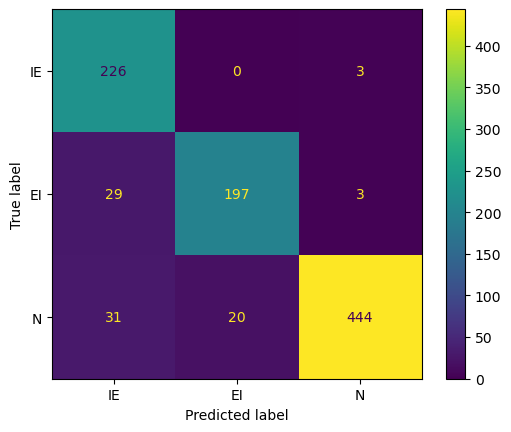

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['IE','EI','N']).plot()

## Implementación con la librería sk-learn (formato de etiquetas one-hot)

El conjunto de letras, según orden alfabético {A, C, G, T}  se convierte según un formato One-hot hacia un vector numérico de 4 dimensiones. Dando lugar a las siguientes conversiones:

A -> (1, 0, 0, 0)
C -> (0, 1, 0, 0)
G -> (0, 0, 1, 0)
T -> (0, 0, 0, 1)

Permite una mayor suavidad en el cambio de rango numérico al cambiar de valor de etiqueta, lo que puede permitir unos mejor ajustes

### Obtener la matriz de 60 columnas.

In [45]:
X_train60 = [[letra for letra in fila] for fila in X_train]
X_test60 = [[letra for letra in fila] for fila in X_test]
print(len(X_train60), len(X_train60[0]), len(y_train))
print(len(X_test60), len(X_test60[0]), len(y_test))
dfw = pd.DataFrame(X_train60)
dfw.head()

2222 60 2222
953 60 953


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,G,A,T,G,T,T,A,A,C,C,...,A,A,T,C,A,G,C,C,C,T
1,G,T,C,T,T,T,G,C,T,T,...,C,A,G,G,C,G,A,T,G,G
2,C,C,T,G,T,C,T,C,C,T,...,G,G,G,C,C,G,A,T,T,T
3,C,T,A,C,A,G,C,A,G,C,...,G,T,C,C,T,G,T,C,C,A
4,T,G,G,A,G,A,C,T,C,A,...,A,C,T,A,T,G,C,C,G,G


### Convertir las etiquetas al formato one-hot

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train60)
X_train240 = enc.transform(X_train60).toarray()
X_test240 = enc.transform(X_test60).toarray()
X_train240.shape, X_test240.shape

((2222, 240), (953, 240))

In [47]:
dfw = pd.DataFrame(X_train240)
dfw.head()

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Repetir el entrenamiento y validación

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
clf_NB = GaussianNB()
clf_NB.fit(X_train240, y_train)
y_pred = clf_NB.predict(X_test240)
print('Exactitud - Accuracy: %.4f' % accuracy_score(y_true=y_test, y_pred=y_pred))

Exactitud - Accuracy: 0.9161


_La exactitud ha mejorado ligeramente al usar el formato one-hot!_